In [1]:
import cv2
import pytesseract
from pytesseract import Output
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from ocrutils.imageops import is_a_picture, prepare_image
from collections import Counter

Carregando imagem

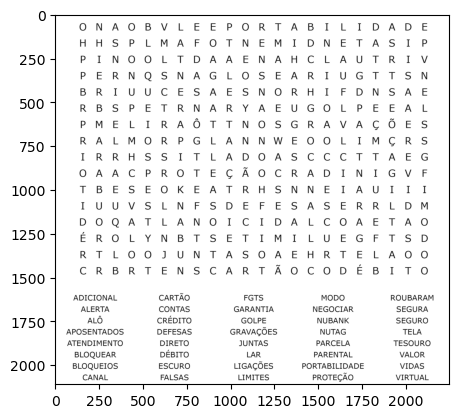

In [2]:
img_path = Path.cwd().joinpath('data','wordsearch.png')
img = cv2.imread(str(img_path.resolve()))
plt.imshow(img)

config tesseract

In [3]:
# whitelist dosent work well with pre-treineds por models 

tessdata_dir = Path.cwd().joinpath('tessdata')                              #path to dir with de model treined in portugues
blacklist = "0123456789!#$%&'&*()*+,-./:;<=>?@[\]^_`{|}~"   
blacklist += '"'                         
config_img = f'-l por --psm 11 --tessdata-dir {tessdata_dir}'               # psm 11 não detecta bem o formato de caca palavras, apenas as palavras para serem cacadas.
config_wordsearch_area= f'-l por --psm 6 --tessdata-dir {tessdata_dir} textord_heavy_nr=1 ' 
config_wordsearch_letter = f'-l por --psm 6 --tessdata-dir {tessdata_dir} textord_heavy_nr=1'   # psm 10 or 8 should work butter (for single caracter), but when it used, confuses p with d (psm 10) and (psm 8) fail too


Gray + threshold

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

Reconhecimento das regiões

In [5]:
#img_data -> dict with detection information

if (is_a_picture(img)):
    img = prepare_image(img)
    img_data = pytesseract.image_to_data(img, config=config_img, lang ='por', output_type=Output.DICT)

else:
    img_data = pytesseract.image_to_data(img, config=config_img, output_type=Output.DICT)

Fuctions to use

In [ ]:
def words_area(data: dict, img) -> tuple:
    #tuple -> (x1,y1,x2,y2)

    img_h, img_w = img.shape[:2]  
    chaves = list(data.keys())
    size = len(data[chaves[0]])
    left_min, top_min, bottom_max, right_max = img_w, img_h, 0, 0
    #left_min = posicao mais a esquerda possivel
    #top_min = posicao mais alto possivel
    for i in range(size):
        if len(data['text'][i]) > 3:
            x = data['left'][i]
            y = data['top'][i]
            w = data['width'][i]
            h = data['height'][i]
            
            left_min = min(left_min, x)
            top_min = min(top_min, y)
            right_max = max(right_max, x + w)
            bottom_max = max(bottom_max, y + h)

    return left_min, top_min, right_max, bottom_max

def words_to_search(data : dict, img) -> tuple:
    #tuple -> (img_zoom, words_list)
    
    x1, y1, x2, y2 = words_area(data, img)
    img_zoom = img[y1:y2,x1:x2]
    data = pytesseract.image_to_data(img_zoom, config=config_img, lang ='por', output_type=Output.DICT)

    spaces_index_list = []
    for i, word in enumerate(data['text']):
        if word == '':
            spaces_index_list.append(i)

    words_list = [word for i, word in enumerate(data['text']) if i not in spaces_index_list]
  
    return (img_zoom, words_list)

def search_words_area(data: dict, img) -> tuple:
    #tuple -> (x1,y1,x2,y2)

    x1, y1, x2, y2 = words_area(data, img)
    img_wordsearch = img.copy()

    # delete words area (left it white)
    img_wordsearch[y1:y2,x1:x2] = 255
    img_h, img_w = img_wordsearch.shape[:2]  
    left_min, top_min, bottom_max, right_max = img_w, img_h, 0, 0
    data_img_wordsearch = pytesseract.image_to_data(img_wordsearch, config = config_wordsearch_area, output_type= Output.DICT)

    for i, letter in enumerate(data_img_wordsearch['text']):
        if letter != '' and letter not in blacklist:
            x = data_img_wordsearch['left'][i]
            y = data_img_wordsearch['top'][i]
            w = data_img_wordsearch['width'][i]
            h = data_img_wordsearch['height'][i]
            
            left_min = min(left_min, x)
            top_min = min(top_min, y)
            right_max = max(right_max, x + w)
            bottom_max = max(bottom_max, y + h)

    return left_min, top_min, right_max, bottom_max

def search_words_matrix(data: dict, img) -> list:
    x1, y1, x2, y2 = search_words_area(data, img)
    img_wordsearch = img[y1:y2, x1:x2]
    data_img_wordsearch = pytesseract.image_to_data(img_wordsearch, config = config_wordsearch_area, output_type= Output.DICT)
    #remove spaces 
    space_index = []

    for i, valeu in enumerate(data_img_wordsearch['text']):
        if valeu == '':
            space_index.append(i)

    data_img_wordsearch = {
        key: [value for i, value in enumerate(values) if i not in space_index]
        for key, values in data_img_wordsearch.items()
    }

    # mode of the number of letters detect in each line
    num_of_letters_dic = []
    for i, valeu in enumerate(data_img_wordsearch['text']):
        line = data_img_wordsearch['line_num'][i]
        if line > len(num_of_letters_dic):
            num_of_letters_dic.append(len(data_img_wordsearch['text'][i]))
        else:
            num_of_letters_dic[line - 1] += len(data_img_wordsearch['text'][i])
    
    count = Counter(num_of_letters_dic)
    colum_num = count.most_common()[0][0]                       # number of coluns
    line_num = len(set(data_img_wordsearch['line_num']))        # number of lines

    letter_height= round((img_wordsearch.shape[0] / (line_num)))    # espaços verticais entre as palavras
    letter_width = round((img_wordsearch.shape[1]/ (colum_num )))    # espaços horizontais entra as palavras

    y_letters_begin = round(y1 - letter_height/4)
    x_letters_begin = round(x1 - letter_width/4)

    letter_height= round(((img_wordsearch.shape[0] + (letter_height/2)) / (line_num )))    # espaços verticais entre as palavras (tendo somado mais espaço as extremidades)
    letter_width = round(((img_wordsearch.shape[1] + (letter_width/2)) / (colum_num )))    # espaços horizontais entra as palavras (tendo somado mais espaço as extremidades)

    matriz = [[0 for _ in range(colum_num)] for _ in range(line_num)]

    #por algum motivo a detecção de "p" esta ruim, ele detecta 'd' no lugar do 'p' 
    for i in range(line_num):
        x_letters_begin_copy = x_letters_begin # restart x 

        for j in range (colum_num):

            #letter img
            img_wordsearch_letter = img[y_letters_begin:y_letters_begin + letter_height, x_letters_begin_copy: x_letters_begin_copy + letter_width]
            data_img_wordsearch_letter = pytesseract.image_to_data(img_wordsearch_letter, config = config_wordsearch_letter, output_type= Output.DICT)

            #removing possible spaces '' detections 
            data_img_wordsearch_letter = {
                key: [value for i, value in enumerate(values) if data_img_wordsearch_letter['text'][i] != '']
                for key, values in data_img_wordsearch_letter.items()
            }

            #adapting the coordinates to the original image
            data_img_wordsearch_letter['left'][0] = x_letters_begin_copy + data_img_wordsearch_letter['left'][0]
            data_img_wordsearch_letter['top'][0]  = y_letters_begin + data_img_wordsearch_letter['top'][0]

            matriz[i][j] = data_img_wordsearch_letter

            x_letters_begin_copy += letter_width 
        y_letters_begin += letter_height
    return matriz

def search_ritgh(matrix, r, c, word) -> tuple:
    # tuple -> (x1,y1,x2,y2)
    # r -> role
    # c -> column 
    try:
        for i, letter in enumerate(word):
            if matrix[r][c+i] == letter:
                continue
            else:
                return None
        return (matrix[r][c]['top'], matrix[r][c]['left'], matrix[r][c + len(word)]['top'], matrix[r][c + len(word)]['left'])
    except (IndexError):
        return None


def search_direction(matrix, r : int, c : int, word : str, direction: str):
    # return -> index of last letter (role, colum)
    # r -> role
    # c -> column 
    # dr -> direction role
    # dc -> direction column
    match direction:
        case 'search_ritgh':
            dr = 0
            dc = 1
        case 'search_left':
            dr = 0
            dc = -1
        case 'search_down':
            dr = 1
            dc = 0
        case 'search_up':
            dr = -1
            dc = 0
        case 'search_up_rigth':
            dr = -1
            dc = 1
        case 'search_up_left':
            dr = -1
            dc = -1
        case 'search_down_rigth':
            dr = 1
            dc = 1
        case 'search_down_left':
            dr = 1
            dc = -1
    try:
        for i, letter in enumerate(word):
            if matrix[r+(i * dr)][c + (i* dc)] == letter:
                if i == len(word) - 1:
                    last_index = (r+(i * dr), c + (i* dc)) 
                continue
            else:
                return None 
        return last_index
    except (IndexError):
        return None

def complete_word_search(data : dict, img):
    _, words_list = words_to_search(data, img)
    matrix = search_words_matrix(data, img)
    directions = ['search_ritgh', 'search_left', 'search_down', 'search_up', 'search_up_rigth', 'search_up_left', 'search_down_rigth', 'search_down_left']

    coordenadas = []                                                            #list of tuples (x1,y1,x2,y2)
    letter_matrix = [[element['text'] for element in line] for line in matrix]  #better to use a matrix of letters for de function
    for r in range(len(matrix)):
        for c in range(len(matrix[r])):
                for word in words_list:
                    # checks that the word has as its first letter the letter
                    if matrix[r][c]['text'] == word[0]:
                        # try all the directions until one of them works, break if works and try other word
                        for direction in directions:
                            last_index = search_direction(letter_matrix, r, c, word, direction)
                            if last_index is not None:
                                coordenadas.append(matrix[r][c]['left'], matrix[r][c]['top'], matrix[last_index[0]][last_index[1]]['left'], [last_index[0]][last_index[1]]['top'])
                                words_list.remove(word)
                                break 
    #circulate the words
    img_copy = img.copy()
    for coordenada in coordenadas:
        cv2.rectangule(img_copy, coordenada[:2], coordenada[2:4], 0, 2)
    return img_copy

img_complete = complete_word_search(img_data, img)

plt.imshow(img_complete)


TypeError: list indices must be integers or slices, not list

function words_area working

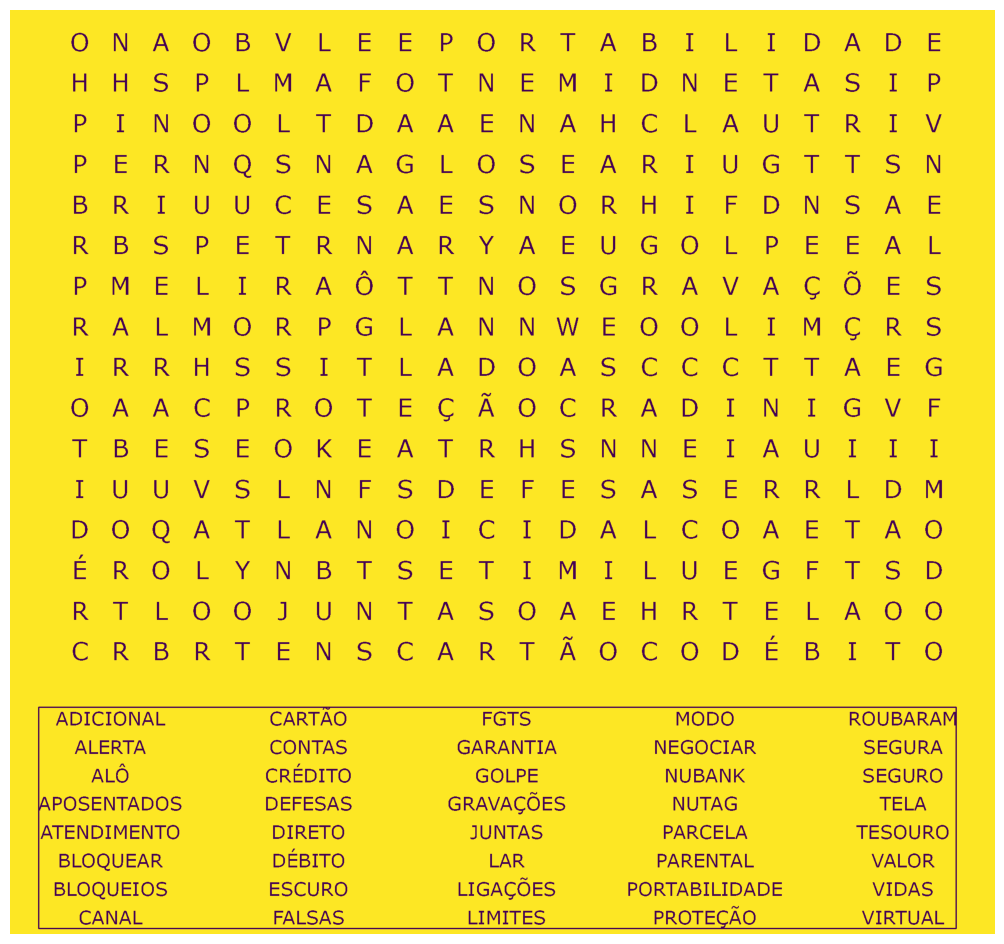

In [ ]:
x1, y1, x2, y2 = words_area(img_data, img)
img_copi = img.copy()
cv2.rectangle(img_copi, (x1, y1), (x2, y2), 0, 2)
plt.figure(figsize=(15, 12))
plt.imshow(img_copi)
plt.axis('off')
plt.show()   

fucntion words_to_search working

['ADICIONAL', 'CARTÃO', 'FGTS', 'MODO', 'ROUBARAM', 'ALERTA', 'CONTAS', 'GARANTIA', 'NEGOCIAR', 'SEGURA', 'ALÔ', 'CRÉDITO', 'GOLPE', 'NUBANK', 'SEGURO', 'APOSENTADOS', 'DEFESAS', 'GRAVAÇÕES', 'NUTAG', 'TELA', 'ATENDIMENTO', 'DIRETO', 'JUNTAS', 'PARCELA', 'TESOURO', 'BLOQUEAR', 'DÉBITO', 'LAR', 'PARENTAL', 'VALOR', 'BLOQUEIOS', 'ESCURO', 'LIGAÇÕES', 'PORTABILIDADE', 'VIDAS', 'CANAL', 'FALSAS', 'LIMITES', 'PROTEÇÃO', 'VIRTUAL']


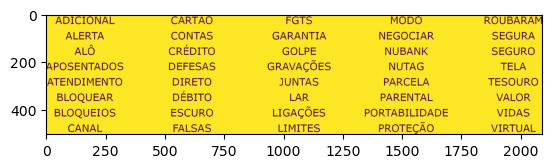

In [ ]:
img_zoom, words_list = words_to_search(img_data, img)
print(words_list)
plt.imshow(img_zoom)

function search_words_area() working

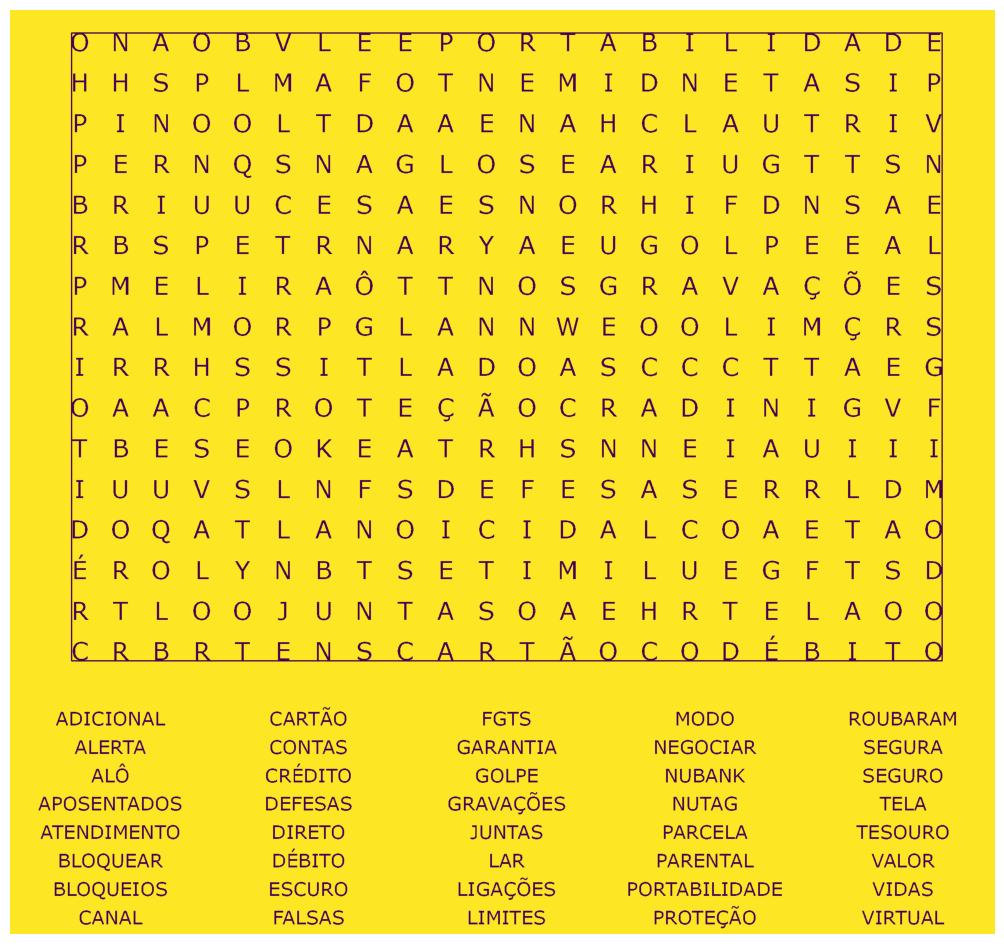

In [ ]:
x1, y1, x2, y2 = search_words_area(img_data, img)
img_copi = img.copy()
cv2.rectangle(img_copi, (x1, y1), (x2, y2), 0, 2)
plt.figure(figsize=(15, 12))
plt.imshow(img_copi)
plt.axis('off')
plt.show()   